In [1]:
# [0]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysimul
import os
import csv

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# [1]
def plot_means_synth (t, X, cmak=4):
    plt.figure(figsize=(15,5))
    plt.plot(t, X, lw=1, color='royalblue')
    if cmak != 0:
        plt.plot(t, pysimul.cma(X, cmak), color='navy')
    X_mean = np.mean(X)
    X_std = np.std(X)
    plt.axhline(X_mean, color='darkorange', label="Mean : {:.2e}".format(X_mean))
    plt.fill_between(t, X_mean-X_std, X_mean+X_std, facecolor='orange', alpha=0.3, label="Std. dev. : {:.1e}".format(X_std))
    (X_slope, X0) = np.polyfit(t, X, 1)
    plt.plot(t, X0 + X_slope*t, color='darkorange', lw=1, label="Change : {:.1e}".format(X_slope*(t[-1]-t[0])))
    plt.xlim([t[0],t[-1]])
    plt.legend()
    return (X_mean, X_std, X_slope)

def autocorrel (signal, sΔt, window):
    autoc = np.correlate(signal, signal, 'full')
    a,b = int(len(autoc)/2-window/sΔt), int(len(autoc)/2+window/sΔt)
    if a < 0:
        a = 0
        b = -1
        window = sΔt*len(autoc)/2
    autoc_win = autoc[a:b]
    tau = np.linspace(-window,+window,len(autoc_win))
    return tau, autoc_win

In [3]:
# [2]
simul = pysimul.PySimul()

In [4]:
# [3]
auto_mode = True
flag_end = False
rea_number = 0
do_save = False

In [5]:
auto_mode = False
do_save = False

In [6]:
# [5]
target_T = 300
simul["target_T"] = target_T
simul["enable_fine_stats"] = 0

In [7]:
# [6]
def timer_f ():
    global simul, auto_mode, flag_end
    if simul is None:
        return 1
    simul.sfml_event_poll()
    if auto_mode and flag_end:
        flag_end = False
        return 2
    return 0

In [8]:
%%javascript
var sfml_event_poll_timer = setInterval(function() {
    Jupyter.notebook.kernel.execute("print(timer_f())", { iopub : { output : function (data) {
        if (data.content.text == "1\n" || data.content.text === undefined) {
            clearInterval(sfml_event_poll_timer);
        } else if (data.content.text == "2\n") {
            Jupyter.notebook.execute_cells([17,18,19,20,21,22,13,14,15,23,11,8]);
        }
    }}})
}, 2000);

<IPython.core.display.Javascript object>

In [8]:
# [8]
simul.start()
sstart = 0
sstop = -1
has_beg = False
has_end = False
look_for_release = True
t_beg = 0.17
t_end = 0.30
def regular_callback (step, t):
    global has_beg, t_beg, t_end, flag_end, has_end, simul, look_for_release
    if t > t_beg and not has_beg:
        has_beg = True
        simul["target_T"] = -1
        simul["release_well"] = 1
    if has_beg and look_for_release:
        if simul["release_well"] == 0: # particule has been released
            simul["enable_fine_stats"] = 1
            #simul.reset_series("vdist")
            look_for_release = False
    if has_beg and not has_end:
        t_release_well = simul["release_well_t"]
        if not np.isnan(t_release_well) and t-t_release_well > t_end-t_beg:
            flag_end = True
            has_end = True
            simul["pause"] = 1
simul.set_regular_callback(regular_callback)

In [10]:
#simul["well_k"] = 0
has_beg = has_end = True
look_for_release = False

In [22]:
simul.end()
simul = None

In [764]:
# [11]
simul.end()
rea_number += 1

## Température

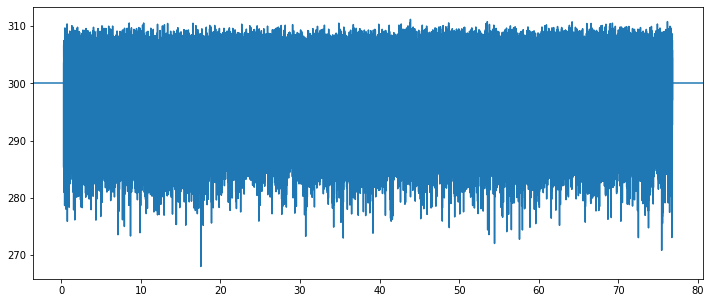

In [119]:
# [13]
simul.explicit_lock()
t = simul["sample_t"]
T = simul["Temp"]
simul.explicit_unlock()
plt.figure(figsize=(12,5))
plt.plot(t, T)
plt.axhline(y=target_T)
None

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


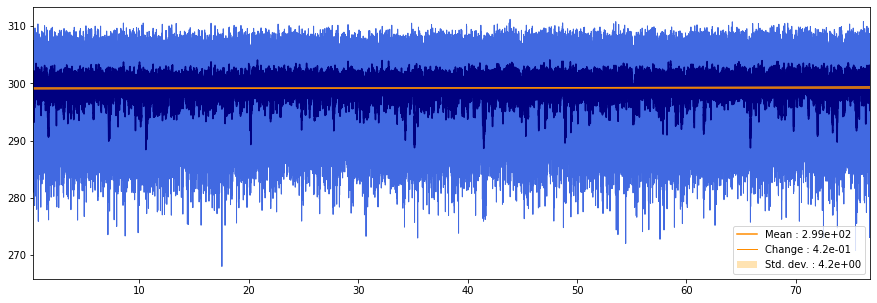

In [120]:
# [14]
(T_mean, T_std, T_slope) = plot_means_synth(t[sstart:sstop], T[sstart:sstop], cmak=20)
if auto_mode or do_save:
    plt.savefig(savepath+"/T_hist.png")

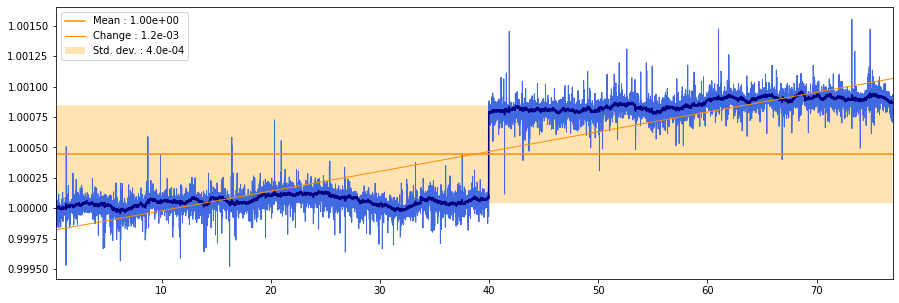

In [121]:
#[15]
simul.explicit_lock()
t = simul["sample_t"]
Epot = simul["Epot"]
Ecin = simul["Ecin"]
simul.explicit_unlock()
Etot = Epot + Ecin
(Er_mean, Er_std, Er_slope) = plot_means_synth(t[sstart:], Etot[sstart:]/Etot[sstart], cmak=10)
if auto_mode or do_save:
    plt.savefig(savepath+"/Etot_hist.png")

## Diffusion libre

In [754]:
# [17]
savepath = "res50/{:03d}".format(rea_number)
if not os.path.exists(savepath):
    os.mkdir(savepath)

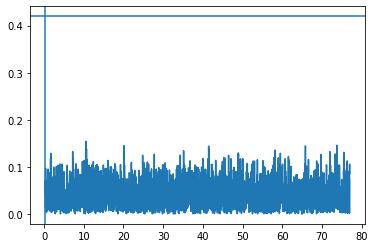

In [122]:
# [18]
simul.explicit_lock()
pt = simul["sample_t"]
px, py = simul["part_x"], simul["part_y"]
cont_r = simul["cont_r"]
part_d = simul["part_d"]
t_beg_exact = simul["release_well_t"]
simul.explicit_unlock()
pr = np.hypot(px-0.5, py-0.5)

if auto_mode:
    sstart = np.searchsorted(pt, t_beg_exact, side='right')
    sstop = np.argmax(pr > cont_r-part_d)
    if sstop == 0:
        sstop = -1
    print(sstart,sstop)

plt.plot(pt[:sstop], pr[:sstop])
plt.axhline(y=cont_r-part_d)
if sstart != len(pt):
    plt.axvline(x=pt[sstart])
if auto_mode or do_save:
    plt.savefig(savepath+"/p_r_hist.pdf")

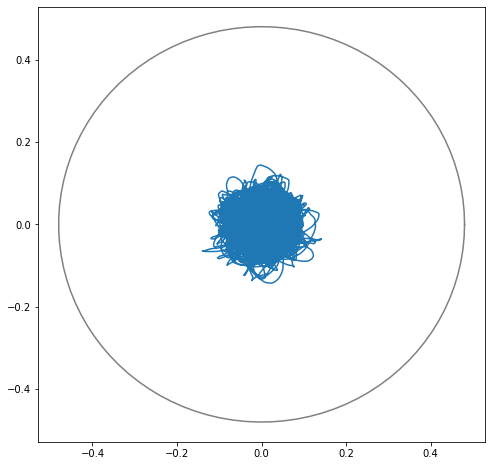

In [123]:
# [19]
plt.figure(figsize=(8,8))
plt.plot(px[sstart:sstop]-0.5, py[sstart:sstop]-0.5)
u = np.linspace(0,2*np.pi,100)
plt.plot(cont_r*np.cos(u), cont_r*np.sin(u), color='grey')
if auto_mode or do_save:
    pd.DataFrame({
        't': pt[sstart:sstop],
        'px': px[sstart:sstop],
        'py': py[sstart:sstop]
    }).to_csv(savepath+"/p_traj.csv", index=False, float_format='%.8f')

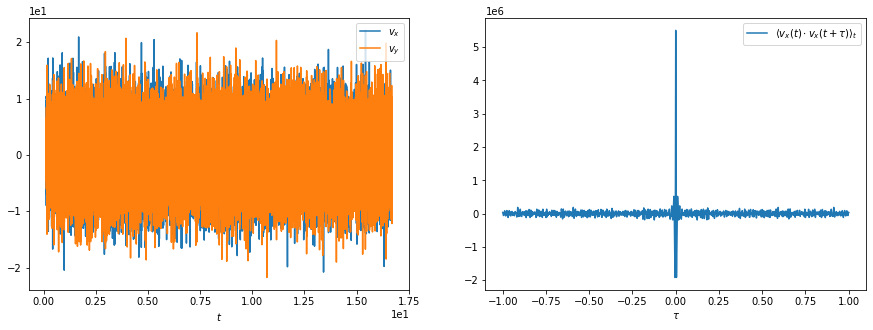

In [29]:
# [20]
simul.explicit_lock()
t = simul["sample_t"]
vx = simul["part_vx"]
vy = simul["part_vy"]
simul.explicit_unlock()
sΔt = np.mean(np.diff(t))

fix, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(t[sstart:sstop], vx[sstart:sstop], label="$v_x$")
ax1.plot(t[sstart:sstop], vy[sstart:sstop], label="$v_y$")
ax1.set_xlabel("$t$")
ax1.legend()
ax1.ticklabel_format(style='sci', scilimits=(0,0))

tau, v_autocor_xx = autocorrel(vx[sstart:sstop], sΔt, 1e0)
ax2.plot(tau, v_autocor_xx, label=r"$\langle v_x(t) \cdot v_x(t+\tau) \rangle_t$")
ax2.set_xlabel(r"$\tau$")
ax2.legend()
ax2.ticklabel_format(style='sci', scilimits=(0,0))

if auto_mode or do_save:
    pd.DataFrame({
        'tau': tau,
        'c_vx_vx': v_autocor_xx,
    }).to_csv(savepath+"/c_vx_vx.csv", index=False, float_format='%.5e')

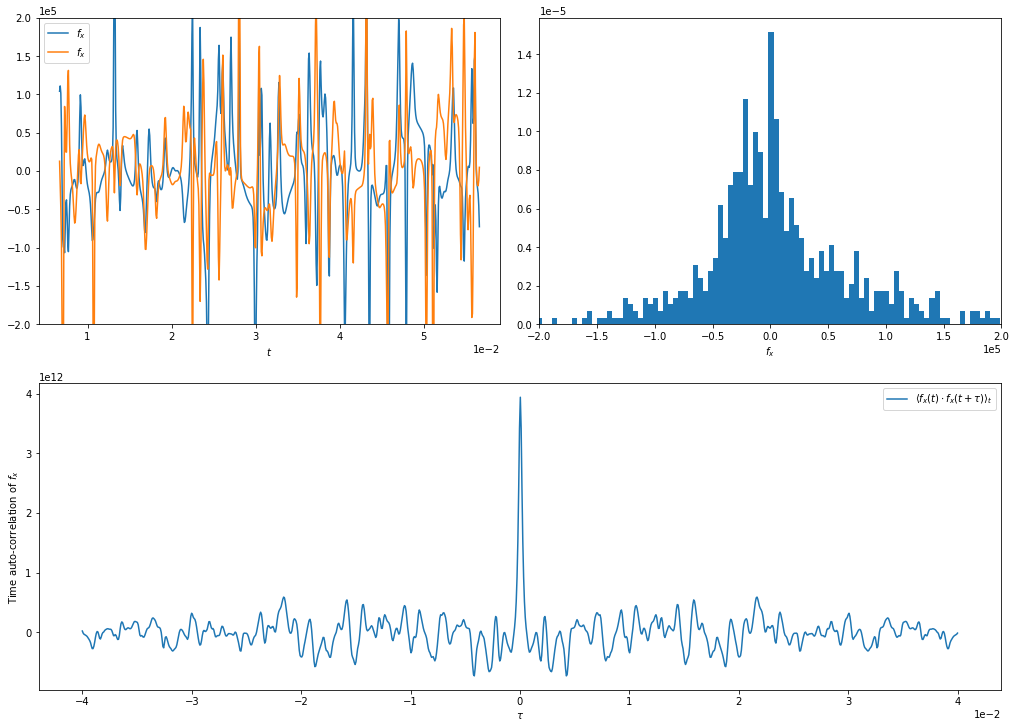

In [18]:
# [21]
simul.explicit_lock()
t = simul["sample_t"]
fx = simul["part_fx"]
fy = simul["part_fy"]
simul.explicit_unlock()
sΔt = np.mean(np.diff(t))

fig = plt.figure(constrained_layout=True, figsize=(14,10))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(t[sstart:sstop], fx[sstart:sstop], label='$f_x$')
ax1.plot(t[sstart:sstop], fy[sstart:sstop], label='$f_x$')
ax1.legend()
ax1.set_xlabel("$t$")
ax1.set_ylim((-2e5,+2e5))
ax1.ticklabel_format(style='sci', scilimits=(0,0))

ax2 = fig.add_subplot(gs[0,1])
ax2.hist(fx[sstart:sstop], bins=200, density=True)
ax2.set_xlabel("$f_x$")
ax2.set_xlim((-2e5,+2e5))
ax2.ticklabel_format(style='sci', scilimits=(0,0))

ax3 = fig.add_subplot(gs[1,:])
tau, f_autocor_xx = autocorrel(fx[sstart:sstop], sΔt, 4e-2)
ax3.plot(tau, f_autocor_xx, label=r"$\langle f_x(t) \cdot f_x(t+\tau) \rangle_t$")
ax3.legend()
ax3.set_xlabel(r"$\tau$")
ax3.set_ylabel(r"Time auto-correlation of $f_x$")
ax3.ticklabel_format(style='sci', scilimits=(0,0))

if auto_mode or do_save:
    plt.savefig(savepath+"/f.pdf")
    pd.DataFrame({
        'tau': tau,
        'c_fx_fx': f_autocor_xx,
    }).to_csv(savepath+"/c_fx_fx.csv", index=False, float_format='%.4e')

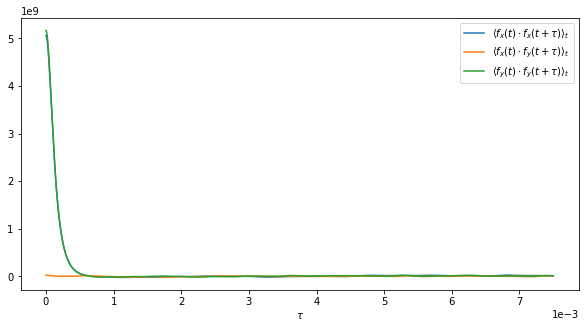

In [124]:
# [22]
plt.figure(figsize=(10,5))

Δt = simul["Delta_t"]

(acc, samples) = simul["f_autocor_xx"]
f_autocor_xx = acc / samples
tau = Δt*np.arange(0,len(f_autocor_xx),1)
plt.plot(tau, f_autocor_xx, label=r"$\langle f_x(t) \cdot f_x(t+\tau) \rangle_t$")

(acc, samples) = simul["f_autocor_xy"]
f_autocor_xy = acc / samples
plt.plot(tau, f_autocor_xy, label=r"$\langle f_x(t) \cdot f_y(t+\tau) \rangle_t$")

(acc, samples) = simul["f_autocor_yy"]
f_autocor_yy = acc / samples
plt.plot(tau, f_autocor_yy, label=r"$\langle f_y(t) \cdot f_y(t+\tau) \rangle_t$")

plt.legend()
plt.xlabel(r"$\tau$")
plt.ticklabel_format(style='sci', scilimits=(0,0))

if auto_mode or do_save:
    pd.DataFrame({
        'tau': tau,
        'c_fx_fx': f_autocor_xx,
        'c_fy_fy': f_autocor_yy,
        'c_fx_fy': f_autocor_xy,
    }).to_csv(savepath+"/c_f_f_fine.csv", index=False, float_format='%.4e')

In [763]:
# [23]
results = {}

results['T'] = T_mean
results['T_std'] = T_std
results['T_slope'] = T_slope
results['Etot_rel_slope'] = Er_slope
results['t_beg_exact'] = t_beg_exact

df = pd.DataFrame(list(results.items())).set_index(0)
_ = df.to_csv(savepath+"/res.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')

## Distribution des vitesses

In [ ]:
simul.reset_series("vdist")

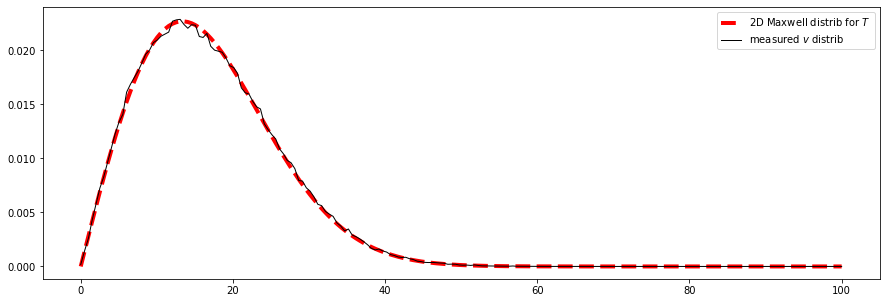

In [35]:
plt.figure(figsize=(15,5))
(acc, samples) = simul["vdist"]
v = np.linspace(0,1e2,len(acc))
d = acc/samples

m = 1
def maxwell_distr_2D (v, T):
    return (m/(2*T))* v * np.exp(-m * v**2 /(2*T))
plt.plot(v, maxwell_distr_2D(v, T_mean), '--', color='red', lw=4, label='2D Maxwell distrib for $T$')

plt.plot(v, d, lw=1, color='black', label='measured $v$ distrib')

plt.legend()
if auto_mode or do_save:
    plt.savefig(savepath+"/v_distr.pdf")

## Distribution de la position

In [9]:
simul.start()

In [11]:
simul.explicit_lock()
simul["target_T"] = -1
simul["enable_fine_stats"] = 1
simul.reset_series("sample_t")
simul.reset_series("Temp")
simul.reset_series("part_x")
simul.reset_series("part_y")
simul.reset_series("part_fx")
simul.reset_series("part_fy")
simul.reset_series("part_vx")
simul.reset_series("part_vy")
simul.reset_series("Ecin")
simul.reset_series("Epot")
simul["well_k"] = 1e3
simul.reset_series("xdist")
simul.reset_series("rdist")
simul['part_T'] = 0
simul['part_T_samples'] = 0
simul.explicit_unlock()
sstart = 0
sstop = -1

In [111]:
do_save = True
savepath = "well42"

#### Several ways to compute temperature by the equirepartition theorem

In [112]:
T_well_x = 2 * np.mean( simul["well_k"]/2 * (simul["part_x"]-0.5)**2 )
T_well_y = 2 * np.mean( simul["well_k"]/2 * (simul["part_y"]-0.5)**2 )
T_well = (T_well_x + T_well_y)/2
T_well_x, T_well_y

(1.4189844523241735, 1.438974167569966)

In [113]:
T_part_x = 2 * np.mean( simul["part_m"]/2 * simul["part_vx"]**2 )
T_part_y = 2 * np.mean( simul["part_m"]/2 * simul["part_vy"]**2 )
T_part = simul['part_T']/simul['part_T_samples']
T_part_x, T_part_y, T_part

(278.50145511131393, 282.8437361163483, 284.5374891677707)

In [114]:
np.mean(simul['Temp'])

299.203683895798

#### Position distribution

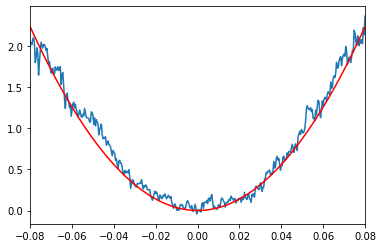

In [116]:
(acc, samples) = simul["xdist"]
xdist = acc/samples
xdist_max = simul["xdist_max"]
x = np.linspace(-xdist_max,xdist_max,len(xdist))
with np.errstate(divide='ignore'):
    U_kT = -np.log(xdist)
U_kT -= U_kT[len(x)//2]
plt.plot(x, U_kT)
plt.xlim((-xdist_max,xdist_max))
k = simul['well_k']
plt.plot(x, k/2*x**2/T_well, color='red')

if do_save:
    plt.savefig(savepath+"/xdistr.pdf")
    pd.DataFrame({
        'x': x,
        'proba': xdist,
    }).to_csv(savepath+"/xdistr.csv", index=False, float_format='%.10e')

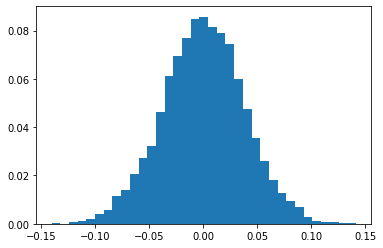

In [117]:
x_part = simul["part_x"]-0.5
bins,h,_ = plt.hist(x_part, bins=35, weights=np.ones(len(x_part))/len(x_part))

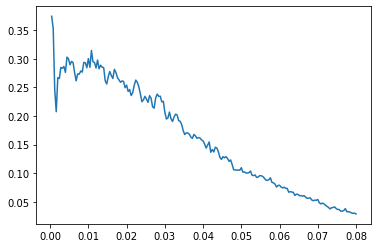

In [118]:
(acc, samples) = simul["rdist"]
rdist = acc/samples
r = np.linspace(0,xdist_max,len(rdist))
with np.errstate(divide='ignore', invalid='ignore'):
    plt.plot(r, rdist/r)
if do_save:
    plt.savefig(savepath+"/rdistr.pdf")
    pd.DataFrame({
        'r': r,
        'proba': rdist,
    }).to_csv(savepath+"/rdistr.csv", index=False, float_format='%.10e')

In [125]:
params = {}
params['T'] = T_mean
params['T_std'] = T_std
params['T_slope'] = T_slope
params['target_T'] = target_T
params['Etot_rel_slope'] = Er_slope
params['N_gas'] = simul.N
params['Delta_t'] = simul['Delta_t']
params['d0'] = 0.03
params['E0'] = 2.0
params['cont_r'] = simul['cont_r']
params['part_d'] = simul['part_d']
params['part_E0'] = 2.0
params['part_m'] = simul['part_m']
params['well_k'] = simul['well_k']
params['T_part'] = T_part
params['T_well'] = T_well

df = pd.DataFrame(list(params.items())).set_index(0)
_ = df.to_csv(savepath+"/params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')